**Authors**

Robert Flanagan 21311625
Cathal Crowe 21320128

This code runs to the end with no errors.

**Dataset Source** 

https://www.kaggle.com/datasets/gpiosenka/cats-in-the-wild-image-classification/data?select=train

**LeNet Sources**

Persson, A. 2020. Pytorch LeNet Implementation: https://www.youtube.com/watch?v=fcOW-Zyb5Bo

LeCun, Y., et al. 1998. Gradient Based Learning Applied to Document Recognition: http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

PyTorch Documentation, Adam Optimiser, and Cross-Entropy Loss Function: https://pytorch.org/docs

**ResNet Sources**

Basic Setup: https://www.youtube.com/watch?v=CnJC2kj3jxg

Additional Ideas for improving accuracy while avoiding overfitting: https://medium.com/@anglilian/image-classification-with-resnet-pytorch-1e48a4c33905

Paper on residual learning: https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

sklearn documentation for graphs: https://scikit-learn.org/dev/api/sklearn.metrics.html

# LeNet-5 Implementation

## Imports

In [167]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import pandas as pd

## Hyperparameters

In [168]:
# Hyperparameters for the model
BATCH_SIZE = 16 # Provides a good balance between convergence speed and computational cost
LEARNING_RATE = 0.0005 # Good learning rate for Adam optimizer
EPOCHS = 25 # Enough epochs to allow convergence
DROPOUT = 0.5 # Dropout rate for regularization
N_FOLDS = 5 # 5 folds is a good balance between computational cost and model performance

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Apply Transforms + Load Datasets

In [169]:
# Transforms for the data
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)), # Resize images to 224x224
        transforms.RandomRotation(15), # Randomly rotate images by 15 degrees to increase variability in the dataset
        transforms.RandomHorizontalFlip(), # Randomly flip images horizontally to increase variability in the dataset
        transforms.ToTensor(), # Convert images to tensors for PyTorch
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # Normalize images with ImageNet mean and standard deviation for quicker convergence
    ]
)

# Data directories
data_dir = "./data"
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

## Model Implementation

In [170]:
# LeNet-5 Model definition slightly modified to handle 224x224 images with 3 channels (RGB)
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.relu = nn.ReLU() # ReLU activation function
        self.pool = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)) # Average pooling layer
        self.dropout = nn.Dropout(DROPOUT) # Dropout layer

        # Convolutional layers
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=6,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )

        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )

        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=120,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )

        # Calculate the flattened size after the convulutional layers
        self.flattened_size = 120 * 24 * 24

        # Fully connected layers
        self.linear1 = nn.Linear(self.flattened_size, 84)
        self.linear2 = nn.Linear(84, 10)

    def forward(self, x):
        # Convolutional layers with ReLU and Pooling
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))
        x = self.pool(x)

        # Flatten the output for the fully connected layer
        x = x.reshape(x.shape[0], -1)

        # Fully connected layers with ReLU and Dropout
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)

        return x

## Train and Evaluate model during training

In [171]:
# Train and evaluate model during training
def train_and_evaluate(model, train_loader, valid_loader, optimizer, criterion):
    # Initialize lists to store training and validation metrics
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    for epoch in range(EPOCHS):
        # Training Phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Training")
        
        for inputs, labels in train_bar:
            # Move data to device and reset gradients
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            train_bar.set_postfix(
                loss=train_loss / (train_bar.n + 1),
                accuracy=(train_correct / train_total) * 100
            )

        # Calculate epoch training metrics
        epoch_train_acc = (train_correct / train_total) * 100
        epoch_train_loss = train_loss / len(train_loader)
        train_accuracies.append(epoch_train_acc)
        train_losses.append(epoch_train_loss)

        print(f"Epoch {epoch+1}/{EPOCHS}, "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Train Accuracy: {epoch_train_acc:.2f}%")

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        valid_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Validation")
        
        with torch.no_grad():
            for inputs, labels in valid_bar:
                # Move data to device
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Update metrics
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                # Update progress bar
                valid_bar.set_postfix(accuracy=(val_correct / val_total) * 100)

        # Calculate epoch validation metrics
        epoch_val_acc = (val_correct / val_total) * 100
        epoch_val_loss = val_loss / len(valid_loader)
        val_accuracies.append(epoch_val_acc)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{EPOCHS}, "
              f"Validation Loss: {epoch_val_loss:.4f}, "
              f"Validation Accuracy: {epoch_val_acc:.2f}%")

    return train_accuracies, val_accuracies, train_losses, val_losses

## Evaluate model after training

In [172]:
# Evaluate model on test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = correct / total * 100
    print(f"Test Accuracy: {test_acc:.2f}%")
    return test_acc

## Train our model

In [173]:
print("Using device:", device)

# Lists to store metrics for each fold
all_train_accuracies = []
all_val_accuracies = []
all_train_losses = []
all_val_losses = []
all_test_accuracies = []

# Setup K-Fold cross-validation
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Perform K-Fold cross-validation
for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
    print(f"Starting fold {fold+1}/{N_FOLDS}")

    # Split the dataset into training and validation subsets
    train_subset = torch.utils.data.Subset(train_dataset, train_indices)
    valid_subset = torch.utils.data.Subset(train_dataset, val_indices)

    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_subset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize fresh model for this fold
    model = LeNet().to(device)

    # Setup loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Train and evaluate the model
    train_accuracies, val_accuracies, train_losses, val_losses = train_and_evaluate(
        model, train_loader, valid_loader, optimizer, criterion
    )
    test_acc = evaluate_model(model, test_loader)

    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_test_accuracies.append(test_acc)

Using device: cuda
Starting fold 1/5


Epoch 1/25 Training: 100%|██████████| 117/117 [00:04<00:00, 26.87it/s, accuracy=13.9, loss=2.28]


Epoch 1/25, Train Loss: 2.2437, Train Accuracy: 13.95%


Epoch 1/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.72it/s, accuracy=22]  


Epoch 1/25, Validation Loss: 2.0229, Validation Accuracy: 22.01%


Epoch 2/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.11it/s, accuracy=23.7, loss=1.97]


Epoch 2/25, Train Loss: 1.9541, Train Accuracy: 23.68%


Epoch 2/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 40.25it/s, accuracy=35]  


Epoch 2/25, Validation Loss: 1.8011, Validation Accuracy: 35.04%


Epoch 3/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.17it/s, accuracy=30.3, loss=1.83]


Epoch 3/25, Train Loss: 1.8177, Train Accuracy: 30.25%


Epoch 3/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.49it/s, accuracy=40.6]


Epoch 3/25, Validation Loss: 1.6456, Validation Accuracy: 40.60%


Epoch 4/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.20it/s, accuracy=34.4, loss=1.73]


Epoch 4/25, Train Loss: 1.7175, Train Accuracy: 34.37%


Epoch 4/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 40.26it/s, accuracy=40.6]


Epoch 4/25, Validation Loss: 1.6620, Validation Accuracy: 40.60%


Epoch 5/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.27it/s, accuracy=37.6, loss=1.68]


Epoch 5/25, Train Loss: 1.6472, Train Accuracy: 37.57%


Epoch 5/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 41.08it/s, accuracy=44.9]


Epoch 5/25, Validation Loss: 1.5240, Validation Accuracy: 44.87%


Epoch 6/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.38it/s, accuracy=39.7, loss=1.59]


Epoch 6/25, Train Loss: 1.5897, Train Accuracy: 39.71%


Epoch 6/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 39.93it/s, accuracy=45.3]


Epoch 6/25, Validation Loss: 1.5344, Validation Accuracy: 45.30%


Epoch 7/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.32it/s, accuracy=40.6, loss=1.55]


Epoch 7/25, Train Loss: 1.5475, Train Accuracy: 40.57%


Epoch 7/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.75it/s, accuracy=49.1]


Epoch 7/25, Validation Loss: 1.4393, Validation Accuracy: 49.15%


Epoch 8/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.37it/s, accuracy=42.3, loss=1.49]


Epoch 8/25, Train Loss: 1.4926, Train Accuracy: 42.28%


Epoch 8/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 40.15it/s, accuracy=52.6]


Epoch 8/25, Validation Loss: 1.4258, Validation Accuracy: 52.56%


Epoch 9/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.27it/s, accuracy=44.3, loss=1.46]


Epoch 9/25, Train Loss: 1.4484, Train Accuracy: 44.25%


Epoch 9/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 40.12it/s, accuracy=50.2]


Epoch 9/25, Validation Loss: 1.3490, Validation Accuracy: 50.21%


Epoch 10/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.35it/s, accuracy=44.8, loss=1.44]


Epoch 10/25, Train Loss: 1.4122, Train Accuracy: 44.84%


Epoch 10/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 40.43it/s, accuracy=51.9]


Epoch 10/25, Validation Loss: 1.3568, Validation Accuracy: 51.92%


Epoch 11/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.14it/s, accuracy=46.4, loss=1.37]


Epoch 11/25, Train Loss: 1.3732, Train Accuracy: 46.45%


Epoch 11/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 40.88it/s, accuracy=55.3]


Epoch 11/25, Validation Loss: 1.2755, Validation Accuracy: 55.34%


Epoch 12/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.49it/s, accuracy=47.3, loss=1.36]


Epoch 12/25, Train Loss: 1.3412, Train Accuracy: 47.30%


Epoch 12/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 41.36it/s, accuracy=55.3]


Epoch 12/25, Validation Loss: 1.2584, Validation Accuracy: 55.34%


Epoch 13/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.32it/s, accuracy=49.9, loss=1.27]


Epoch 13/25, Train Loss: 1.2738, Train Accuracy: 49.92%


Epoch 13/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 40.41it/s, accuracy=48.5]


Epoch 13/25, Validation Loss: 1.4385, Validation Accuracy: 48.50%


Epoch 14/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.53it/s, accuracy=50.6, loss=1.25]


Epoch 14/25, Train Loss: 1.2547, Train Accuracy: 50.61%


Epoch 14/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 40.29it/s, accuracy=56.6]


Epoch 14/25, Validation Loss: 1.2001, Validation Accuracy: 56.62%


Epoch 15/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.69it/s, accuracy=52.2, loss=1.24]


Epoch 15/25, Train Loss: 1.2153, Train Accuracy: 52.16%


Epoch 15/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.35it/s, accuracy=59.6]


Epoch 15/25, Validation Loss: 1.1588, Validation Accuracy: 59.62%


Epoch 16/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.98it/s, accuracy=54.6, loss=1.16]


Epoch 16/25, Train Loss: 1.1592, Train Accuracy: 54.57%


Epoch 16/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.20it/s, accuracy=57.1]


Epoch 16/25, Validation Loss: 1.1801, Validation Accuracy: 57.05%


Epoch 17/25 Training: 100%|██████████| 117/117 [00:06<00:00, 19.23it/s, accuracy=56.5, loss=1.12]


Epoch 17/25, Train Loss: 1.1207, Train Accuracy: 56.49%


Epoch 17/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.85it/s, accuracy=55.1]


Epoch 17/25, Validation Loss: 1.1843, Validation Accuracy: 55.13%


Epoch 18/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.17it/s, accuracy=56.2, loss=1.09]


Epoch 18/25, Train Loss: 1.0872, Train Accuracy: 56.17%


Epoch 18/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.58it/s, accuracy=59]  


Epoch 18/25, Validation Loss: 1.2054, Validation Accuracy: 58.97%


Epoch 19/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.95it/s, accuracy=58.3, loss=1.05]


Epoch 19/25, Train Loss: 1.0450, Train Accuracy: 58.31%


Epoch 19/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 36.92it/s, accuracy=58.5]


Epoch 19/25, Validation Loss: 1.1589, Validation Accuracy: 58.55%


Epoch 20/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.22it/s, accuracy=56.9, loss=1.09]


Epoch 20/25, Train Loss: 1.0710, Train Accuracy: 56.92%


Epoch 20/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 35.02it/s, accuracy=56]  


Epoch 20/25, Validation Loss: 1.2221, Validation Accuracy: 55.98%


Epoch 21/25 Training: 100%|██████████| 117/117 [00:06<00:00, 19.36it/s, accuracy=61.1, loss=1.02] 


Epoch 21/25, Train Loss: 1.0005, Train Accuracy: 61.09%


Epoch 21/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.79it/s, accuracy=54.1]


Epoch 21/25, Validation Loss: 1.2524, Validation Accuracy: 54.06%


Epoch 22/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.86it/s, accuracy=58.1, loss=0.999]


Epoch 22/25, Train Loss: 0.9990, Train Accuracy: 58.10%


Epoch 22/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 36.66it/s, accuracy=58.8]


Epoch 22/25, Validation Loss: 1.1831, Validation Accuracy: 58.76%


Epoch 23/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.73it/s, accuracy=63.3, loss=0.963]


Epoch 23/25, Train Loss: 0.9633, Train Accuracy: 63.28%


Epoch 23/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.20it/s, accuracy=57.1]


Epoch 23/25, Validation Loss: 1.1481, Validation Accuracy: 57.05%


Epoch 24/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.84it/s, accuracy=63, loss=0.931]  


Epoch 24/25, Train Loss: 0.9306, Train Accuracy: 62.96%


Epoch 24/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 36.60it/s, accuracy=57.3]


Epoch 24/25, Validation Loss: 1.1878, Validation Accuracy: 57.26%


Epoch 25/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.04it/s, accuracy=65, loss=0.893]  


Epoch 25/25, Train Loss: 0.8858, Train Accuracy: 64.99%


Epoch 25/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.48it/s, accuracy=60.3]


Epoch 25/25, Validation Loss: 1.0862, Validation Accuracy: 60.26%
Test Accuracy: 66.00%
Starting fold 2/5


Epoch 1/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.85it/s, accuracy=16.8, loss=2.27]


Epoch 1/25, Train Loss: 2.2359, Train Accuracy: 16.84%


Epoch 1/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.72it/s, accuracy=21.4]


Epoch 1/25, Validation Loss: 2.0818, Validation Accuracy: 21.37%


Epoch 2/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.94it/s, accuracy=26.2, loss=1.99]


Epoch 2/25, Train Loss: 1.9940, Train Accuracy: 26.24%


Epoch 2/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 39.57it/s, accuracy=36.3]


Epoch 2/25, Validation Loss: 1.7369, Validation Accuracy: 36.32%


Epoch 3/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.82it/s, accuracy=32.1, loss=1.82]


Epoch 3/25, Train Loss: 1.7910, Train Accuracy: 32.12%


Epoch 3/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.00it/s, accuracy=42.3]


Epoch 3/25, Validation Loss: 1.5699, Validation Accuracy: 42.31%


Epoch 4/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.37it/s, accuracy=35.6, loss=1.71]


Epoch 4/25, Train Loss: 1.6796, Train Accuracy: 35.65%


Epoch 4/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.97it/s, accuracy=41.9]


Epoch 4/25, Validation Loss: 1.5209, Validation Accuracy: 41.88%


Epoch 5/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.45it/s, accuracy=41, loss=1.6]   


Epoch 5/25, Train Loss: 1.5894, Train Accuracy: 41.05%


Epoch 5/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 34.68it/s, accuracy=51.9]


Epoch 5/25, Validation Loss: 1.4234, Validation Accuracy: 51.92%


Epoch 6/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.47it/s, accuracy=41.5, loss=1.59]


Epoch 6/25, Train Loss: 1.5604, Train Accuracy: 41.48%


Epoch 6/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.91it/s, accuracy=54.5]


Epoch 6/25, Validation Loss: 1.3856, Validation Accuracy: 54.49%


Epoch 7/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.09it/s, accuracy=44.4, loss=1.5] 


Epoch 7/25, Train Loss: 1.4787, Train Accuracy: 44.41%


Epoch 7/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.13it/s, accuracy=49.6]


Epoch 7/25, Validation Loss: 1.3832, Validation Accuracy: 49.57%


Epoch 8/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.03it/s, accuracy=46.3, loss=1.43]


Epoch 8/25, Train Loss: 1.4154, Train Accuracy: 46.29%


Epoch 8/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.04it/s, accuracy=56.6]


Epoch 8/25, Validation Loss: 1.2540, Validation Accuracy: 56.62%


Epoch 9/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.10it/s, accuracy=48.6, loss=1.38]


Epoch 9/25, Train Loss: 1.3529, Train Accuracy: 48.64%


Epoch 9/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.82it/s, accuracy=52.6]


Epoch 9/25, Validation Loss: 1.2689, Validation Accuracy: 52.56%


Epoch 10/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.77it/s, accuracy=50.3, loss=1.32]


Epoch 10/25, Train Loss: 1.3101, Train Accuracy: 50.29%


Epoch 10/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 35.98it/s, accuracy=59.6]


Epoch 10/25, Validation Loss: 1.2438, Validation Accuracy: 59.62%


Epoch 11/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.76it/s, accuracy=51.4, loss=1.28]


Epoch 11/25, Train Loss: 1.2659, Train Accuracy: 51.42%


Epoch 11/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.35it/s, accuracy=55.8]


Epoch 11/25, Validation Loss: 1.2558, Validation Accuracy: 55.77%


Epoch 12/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.88it/s, accuracy=53.2, loss=1.22]


Epoch 12/25, Train Loss: 1.2241, Train Accuracy: 53.18%


Epoch 12/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 36.86it/s, accuracy=57.9]


Epoch 12/25, Validation Loss: 1.2465, Validation Accuracy: 57.91%


Epoch 13/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.96it/s, accuracy=54.1, loss=1.22]


Epoch 13/25, Train Loss: 1.2118, Train Accuracy: 54.14%


Epoch 13/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.34it/s, accuracy=61.5]


Epoch 13/25, Validation Loss: 1.2131, Validation Accuracy: 61.54%


Epoch 14/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.09it/s, accuracy=57.6, loss=1.15]


Epoch 14/25, Train Loss: 1.1287, Train Accuracy: 57.56%


Epoch 14/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.02it/s, accuracy=59.4]


Epoch 14/25, Validation Loss: 1.1631, Validation Accuracy: 59.40%


Epoch 15/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.99it/s, accuracy=57.9, loss=1.14]


Epoch 15/25, Train Loss: 1.1225, Train Accuracy: 57.94%


Epoch 15/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.37it/s, accuracy=55.3]


Epoch 15/25, Validation Loss: 1.1685, Validation Accuracy: 55.34%


Epoch 16/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.39it/s, accuracy=57.9, loss=1.12]


Epoch 16/25, Train Loss: 1.0967, Train Accuracy: 57.88%


Epoch 16/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.06it/s, accuracy=60.7]


Epoch 16/25, Validation Loss: 1.1628, Validation Accuracy: 60.68%


Epoch 17/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.28it/s, accuracy=60.3, loss=1.08]


Epoch 17/25, Train Loss: 1.0618, Train Accuracy: 60.34%


Epoch 17/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.05it/s, accuracy=58.1]


Epoch 17/25, Validation Loss: 1.1491, Validation Accuracy: 58.12%


Epoch 18/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.33it/s, accuracy=60.1, loss=1.02]


Epoch 18/25, Train Loss: 1.0159, Train Accuracy: 60.07%


Epoch 18/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 36.41it/s, accuracy=61.8]


Epoch 18/25, Validation Loss: 1.1185, Validation Accuracy: 61.75%


Epoch 19/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.13it/s, accuracy=64.7, loss=0.98] 


Epoch 19/25, Train Loss: 0.9720, Train Accuracy: 64.67%


Epoch 19/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.78it/s, accuracy=64.3]


Epoch 19/25, Validation Loss: 1.0626, Validation Accuracy: 64.32%


Epoch 20/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.74it/s, accuracy=62.5, loss=0.971]


Epoch 20/25, Train Loss: 0.9540, Train Accuracy: 62.53%


Epoch 20/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.02it/s, accuracy=61.5]


Epoch 20/25, Validation Loss: 1.1185, Validation Accuracy: 61.54%


Epoch 21/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.07it/s, accuracy=65.8, loss=0.892]


Epoch 21/25, Train Loss: 0.8919, Train Accuracy: 65.79%


Epoch 21/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 36.78it/s, accuracy=62.8]


Epoch 21/25, Validation Loss: 1.0782, Validation Accuracy: 62.82%


Epoch 22/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.22it/s, accuracy=65.9, loss=0.875]


Epoch 22/25, Train Loss: 0.8672, Train Accuracy: 65.90%


Epoch 22/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 36.69it/s, accuracy=65.8]


Epoch 22/25, Validation Loss: 1.0337, Validation Accuracy: 65.81%


Epoch 23/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.96it/s, accuracy=65.8, loss=0.878]


Epoch 23/25, Train Loss: 0.8704, Train Accuracy: 65.79%


Epoch 23/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 34.00it/s, accuracy=66]  


Epoch 23/25, Validation Loss: 1.0396, Validation Accuracy: 66.03%


Epoch 24/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.89it/s, accuracy=68, loss=0.848]  


Epoch 24/25, Train Loss: 0.8332, Train Accuracy: 67.99%


Epoch 24/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.53it/s, accuracy=61.5]


Epoch 24/25, Validation Loss: 1.1261, Validation Accuracy: 61.54%


Epoch 25/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.28it/s, accuracy=67.6, loss=0.824]


Epoch 25/25, Train Loss: 0.8170, Train Accuracy: 67.61%


Epoch 25/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.58it/s, accuracy=60.7]


Epoch 25/25, Validation Loss: 1.1637, Validation Accuracy: 60.68%
Test Accuracy: 58.00%
Starting fold 3/5


Epoch 1/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.80it/s, accuracy=17.6, loss=2.17]


Epoch 1/25, Train Loss: 2.1748, Train Accuracy: 17.64%


Epoch 1/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 40.18it/s, accuracy=28.6]


Epoch 1/25, Validation Loss: 1.8703, Validation Accuracy: 28.63%


Epoch 2/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.09it/s, accuracy=30.8, loss=1.87]


Epoch 2/25, Train Loss: 1.8532, Train Accuracy: 30.84%


Epoch 2/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 39.18it/s, accuracy=38.7]


Epoch 2/25, Validation Loss: 1.6988, Validation Accuracy: 38.68%


Epoch 3/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.38it/s, accuracy=34.6, loss=1.73]


Epoch 3/25, Train Loss: 1.7309, Train Accuracy: 34.63%


Epoch 3/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 35.75it/s, accuracy=38]  


Epoch 3/25, Validation Loss: 1.6209, Validation Accuracy: 38.03%


Epoch 4/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.84it/s, accuracy=38.4, loss=1.64]


Epoch 4/25, Train Loss: 1.6365, Train Accuracy: 38.43%


Epoch 4/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.42it/s, accuracy=40]  


Epoch 4/25, Validation Loss: 1.5829, Validation Accuracy: 39.96%


Epoch 5/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.78it/s, accuracy=42.3, loss=1.57]


Epoch 5/25, Train Loss: 1.5458, Train Accuracy: 42.33%


Epoch 5/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 34.52it/s, accuracy=48.9]


Epoch 5/25, Validation Loss: 1.4595, Validation Accuracy: 48.93%


Epoch 6/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.61it/s, accuracy=44.2, loss=1.51]


Epoch 6/25, Train Loss: 1.4989, Train Accuracy: 44.20%


Epoch 6/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 36.84it/s, accuracy=46.8]


Epoch 6/25, Validation Loss: 1.4318, Validation Accuracy: 46.79%


Epoch 7/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.03it/s, accuracy=48.9, loss=1.4] 


Epoch 7/25, Train Loss: 1.3965, Train Accuracy: 48.90%


Epoch 7/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 36.36it/s, accuracy=51.7]


Epoch 7/25, Validation Loss: 1.3001, Validation Accuracy: 51.71%


Epoch 8/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.18it/s, accuracy=49, loss=1.36]  


Epoch 8/25, Train Loss: 1.3449, Train Accuracy: 48.96%


Epoch 8/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.88it/s, accuracy=48.3]


Epoch 8/25, Validation Loss: 1.3600, Validation Accuracy: 48.29%


Epoch 9/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.22it/s, accuracy=52.5, loss=1.28]


Epoch 9/25, Train Loss: 1.2848, Train Accuracy: 52.54%


Epoch 9/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.92it/s, accuracy=49.6]


Epoch 9/25, Validation Loss: 1.3625, Validation Accuracy: 49.57%


Epoch 10/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.73it/s, accuracy=53.3, loss=1.28]


Epoch 10/25, Train Loss: 1.2588, Train Accuracy: 53.29%


Epoch 10/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.95it/s, accuracy=51.3]


Epoch 10/25, Validation Loss: 1.2668, Validation Accuracy: 51.28%


Epoch 11/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.52it/s, accuracy=56.4, loss=1.17]


Epoch 11/25, Train Loss: 1.1639, Train Accuracy: 56.39%


Epoch 11/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.15it/s, accuracy=54.1]


Epoch 11/25, Validation Loss: 1.2247, Validation Accuracy: 54.06%


Epoch 12/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.99it/s, accuracy=58.8, loss=1.13]


Epoch 12/25, Train Loss: 1.1299, Train Accuracy: 58.85%


Epoch 12/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 36.59it/s, accuracy=54.5]


Epoch 12/25, Validation Loss: 1.2630, Validation Accuracy: 54.49%


Epoch 13/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.23it/s, accuracy=59.8, loss=1.08]


Epoch 13/25, Train Loss: 1.0785, Train Accuracy: 59.75%


Epoch 13/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 34.49it/s, accuracy=55.3]


Epoch 13/25, Validation Loss: 1.2280, Validation Accuracy: 55.34%


Epoch 14/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.63it/s, accuracy=61.2, loss=1.06]


Epoch 14/25, Train Loss: 1.0486, Train Accuracy: 61.20%


Epoch 14/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.05it/s, accuracy=56.6]


Epoch 14/25, Validation Loss: 1.1447, Validation Accuracy: 56.62%


Epoch 15/25 Training: 100%|██████████| 117/117 [00:06<00:00, 19.38it/s, accuracy=63.1, loss=1.01] 


Epoch 15/25, Train Loss: 1.0094, Train Accuracy: 63.12%


Epoch 15/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.08it/s, accuracy=57.3]


Epoch 15/25, Validation Loss: 1.1237, Validation Accuracy: 57.26%


Epoch 16/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.85it/s, accuracy=63.8, loss=0.965]


Epoch 16/25, Train Loss: 0.9568, Train Accuracy: 63.76%


Epoch 16/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.73it/s, accuracy=58.3]


Epoch 16/25, Validation Loss: 1.1347, Validation Accuracy: 58.33%


Epoch 17/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.80it/s, accuracy=65.4, loss=0.905]


Epoch 17/25, Train Loss: 0.8971, Train Accuracy: 65.42%


Epoch 17/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.50it/s, accuracy=58.1]


Epoch 17/25, Validation Loss: 1.1807, Validation Accuracy: 58.12%


Epoch 18/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.64it/s, accuracy=67, loss=0.906]  


Epoch 18/25, Train Loss: 0.8906, Train Accuracy: 67.02%


Epoch 18/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 39.14it/s, accuracy=57.9]


Epoch 18/25, Validation Loss: 1.2097, Validation Accuracy: 57.91%


Epoch 19/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.73it/s, accuracy=67.7, loss=0.897]


Epoch 19/25, Train Loss: 0.8897, Train Accuracy: 67.72%


Epoch 19/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.78it/s, accuracy=59]  


Epoch 19/25, Validation Loss: 1.1454, Validation Accuracy: 58.97%


Epoch 20/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.85it/s, accuracy=69.7, loss=0.827]


Epoch 20/25, Train Loss: 0.8272, Train Accuracy: 69.70%


Epoch 20/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 35.55it/s, accuracy=60.3]


Epoch 20/25, Validation Loss: 1.1425, Validation Accuracy: 60.26%


Epoch 21/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.86it/s, accuracy=68.9, loss=0.825]


Epoch 21/25, Train Loss: 0.8250, Train Accuracy: 68.95%


Epoch 21/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 39.03it/s, accuracy=59.2]


Epoch 21/25, Validation Loss: 1.2515, Validation Accuracy: 59.19%


Epoch 22/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.70it/s, accuracy=71.1, loss=0.757]


Epoch 22/25, Train Loss: 0.7508, Train Accuracy: 71.08%


Epoch 22/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 33.20it/s, accuracy=61.3]


Epoch 22/25, Validation Loss: 1.1233, Validation Accuracy: 61.32%


Epoch 23/25 Training: 100%|██████████| 117/117 [00:06<00:00, 18.00it/s, accuracy=72.8, loss=0.741]


Epoch 23/25, Train Loss: 0.7415, Train Accuracy: 72.80%


Epoch 23/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 33.52it/s, accuracy=59.6]


Epoch 23/25, Validation Loss: 1.2350, Validation Accuracy: 59.62%


Epoch 24/25 Training: 100%|██████████| 117/117 [00:06<00:00, 19.41it/s, accuracy=75.5, loss=0.686]


Epoch 24/25, Train Loss: 0.6743, Train Accuracy: 75.47%


Epoch 24/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 39.70it/s, accuracy=59.6]


Epoch 24/25, Validation Loss: 1.2572, Validation Accuracy: 59.62%


Epoch 25/25 Training: 100%|██████████| 117/117 [00:07<00:00, 16.40it/s, accuracy=74.3, loss=0.7]  


Epoch 25/25, Train Loss: 0.6940, Train Accuracy: 74.29%


Epoch 25/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 39.73it/s, accuracy=59.4]


Epoch 25/25, Validation Loss: 1.3090, Validation Accuracy: 59.40%
Test Accuracy: 64.00%
Starting fold 4/5


Epoch 1/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.24it/s, accuracy=17.9, loss=2.26]


Epoch 1/25, Train Loss: 2.2183, Train Accuracy: 17.90%


Epoch 1/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.53it/s, accuracy=24.6]


Epoch 1/25, Validation Loss: 2.0640, Validation Accuracy: 24.57%


Epoch 2/25 Training: 100%|██████████| 117/117 [00:06<00:00, 18.80it/s, accuracy=28.5, loss=1.98]


Epoch 2/25, Train Loss: 1.9500, Train Accuracy: 28.54%


Epoch 2/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, accuracy=33.8]


Epoch 2/25, Validation Loss: 1.8321, Validation Accuracy: 33.76%


Epoch 3/25 Training: 100%|██████████| 117/117 [00:06<00:00, 19.25it/s, accuracy=32.2, loss=1.81]


Epoch 3/25, Train Loss: 1.7811, Train Accuracy: 32.18%


Epoch 3/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 40.31it/s, accuracy=40.4]


Epoch 3/25, Validation Loss: 1.6129, Validation Accuracy: 40.38%


Epoch 4/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.38it/s, accuracy=37.6, loss=1.67]


Epoch 4/25, Train Loss: 1.6667, Train Accuracy: 37.57%


Epoch 4/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 40.04it/s, accuracy=41.2]


Epoch 4/25, Validation Loss: 1.5771, Validation Accuracy: 41.24%


Epoch 5/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.13it/s, accuracy=41.2, loss=1.59]


Epoch 5/25, Train Loss: 1.5749, Train Accuracy: 41.21%


Epoch 5/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 39.80it/s, accuracy=50]  


Epoch 5/25, Validation Loss: 1.4136, Validation Accuracy: 50.00%


Epoch 6/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.22it/s, accuracy=43.7, loss=1.53]


Epoch 6/25, Train Loss: 1.5022, Train Accuracy: 43.72%


Epoch 6/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 40.39it/s, accuracy=43.8]


Epoch 6/25, Validation Loss: 1.3980, Validation Accuracy: 43.80%


Epoch 7/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.45it/s, accuracy=44.3, loss=1.45]


Epoch 7/25, Train Loss: 1.4534, Train Accuracy: 44.25%


Epoch 7/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.59it/s, accuracy=49.8]


Epoch 7/25, Validation Loss: 1.3364, Validation Accuracy: 49.79%


Epoch 8/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.00it/s, accuracy=48.3, loss=1.36]


Epoch 8/25, Train Loss: 1.3623, Train Accuracy: 48.26%


Epoch 8/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 36.31it/s, accuracy=50.2]


Epoch 8/25, Validation Loss: 1.3003, Validation Accuracy: 50.21%


Epoch 9/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.19it/s, accuracy=49.7, loss=1.34]


Epoch 9/25, Train Loss: 1.3147, Train Accuracy: 49.71%


Epoch 9/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 40.32it/s, accuracy=48.3]


Epoch 9/25, Validation Loss: 1.3393, Validation Accuracy: 48.29%


Epoch 10/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.28it/s, accuracy=52.3, loss=1.25]


Epoch 10/25, Train Loss: 1.2371, Train Accuracy: 52.27%


Epoch 10/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.20it/s, accuracy=50.4]


Epoch 10/25, Validation Loss: 1.3074, Validation Accuracy: 50.43%


Epoch 11/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.22it/s, accuracy=54.7, loss=1.2] 


Epoch 11/25, Train Loss: 1.1993, Train Accuracy: 54.68%


Epoch 11/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 39.06it/s, accuracy=50]  


Epoch 11/25, Validation Loss: 1.3400, Validation Accuracy: 50.00%


Epoch 12/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.23it/s, accuracy=56.9, loss=1.16]


Epoch 12/25, Train Loss: 1.1424, Train Accuracy: 56.87%


Epoch 12/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 40.23it/s, accuracy=51.1]


Epoch 12/25, Validation Loss: 1.2956, Validation Accuracy: 51.07%


Epoch 13/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.22it/s, accuracy=59.8, loss=1.1] 


Epoch 13/25, Train Loss: 1.1009, Train Accuracy: 59.81%


Epoch 13/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 39.05it/s, accuracy=51.3]


Epoch 13/25, Validation Loss: 1.2579, Validation Accuracy: 51.28%


Epoch 14/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.58it/s, accuracy=59.8, loss=1.07]


Epoch 14/25, Train Loss: 1.0639, Train Accuracy: 59.75%


Epoch 14/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 40.30it/s, accuracy=57.5]


Epoch 14/25, Validation Loss: 1.1943, Validation Accuracy: 57.48%


Epoch 15/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.05it/s, accuracy=61.2, loss=1.02]


Epoch 15/25, Train Loss: 1.0191, Train Accuracy: 61.20%


Epoch 15/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 30.86it/s, accuracy=57.5]


Epoch 15/25, Validation Loss: 1.1875, Validation Accuracy: 57.48%


Epoch 16/25 Training: 100%|██████████| 117/117 [00:06<00:00, 19.16it/s, accuracy=62.5, loss=1.01] 


Epoch 16/25, Train Loss: 1.0047, Train Accuracy: 62.53%


Epoch 16/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 35.25it/s, accuracy=63]  


Epoch 16/25, Validation Loss: 1.0855, Validation Accuracy: 63.03%


Epoch 17/25 Training: 100%|██████████| 117/117 [00:06<00:00, 19.28it/s, accuracy=63.8, loss=0.968]


Epoch 17/25, Train Loss: 0.9677, Train Accuracy: 63.82%


Epoch 17/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 39.85it/s, accuracy=55.6]


Epoch 17/25, Validation Loss: 1.3095, Validation Accuracy: 55.56%


Epoch 18/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.62it/s, accuracy=64, loss=0.943]  


Epoch 18/25, Train Loss: 0.9348, Train Accuracy: 63.98%


Epoch 18/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.73it/s, accuracy=59.6]


Epoch 18/25, Validation Loss: 1.1153, Validation Accuracy: 59.62%


Epoch 19/25 Training: 100%|██████████| 117/117 [00:06<00:00, 19.05it/s, accuracy=66.1, loss=0.909]


Epoch 19/25, Train Loss: 0.9016, Train Accuracy: 66.06%


Epoch 19/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 36.82it/s, accuracy=61.3]


Epoch 19/25, Validation Loss: 1.1349, Validation Accuracy: 61.32%


Epoch 20/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.76it/s, accuracy=66, loss=0.887]  


Epoch 20/25, Train Loss: 0.8797, Train Accuracy: 66.01%


Epoch 20/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 36.18it/s, accuracy=63]  


Epoch 20/25, Validation Loss: 1.0731, Validation Accuracy: 63.03%


Epoch 21/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.53it/s, accuracy=67.9, loss=0.854]


Epoch 21/25, Train Loss: 0.8536, Train Accuracy: 67.93%


Epoch 21/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 36.62it/s, accuracy=61.3]


Epoch 21/25, Validation Loss: 1.1559, Validation Accuracy: 61.32%


Epoch 22/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.83it/s, accuracy=69.5, loss=0.787]


Epoch 22/25, Train Loss: 0.7868, Train Accuracy: 69.48%


Epoch 22/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 36.49it/s, accuracy=59.8]


Epoch 22/25, Validation Loss: 1.0675, Validation Accuracy: 59.83%


Epoch 23/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.08it/s, accuracy=69.9, loss=0.826]


Epoch 23/25, Train Loss: 0.8193, Train Accuracy: 69.86%


Epoch 23/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 39.84it/s, accuracy=56.2]


Epoch 23/25, Validation Loss: 1.1976, Validation Accuracy: 56.20%


Epoch 24/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.77it/s, accuracy=70, loss=0.77]   


Epoch 24/25, Train Loss: 0.7637, Train Accuracy: 69.96%


Epoch 24/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 40.14it/s, accuracy=61.8]


Epoch 24/25, Validation Loss: 1.1067, Validation Accuracy: 61.75%


Epoch 25/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.70it/s, accuracy=72.7, loss=0.769]


Epoch 25/25, Train Loss: 0.7620, Train Accuracy: 72.69%


Epoch 25/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.15it/s, accuracy=61.8]


Epoch 25/25, Validation Loss: 1.1779, Validation Accuracy: 61.75%
Test Accuracy: 76.00%
Starting fold 5/5


Epoch 1/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.21it/s, accuracy=19.9, loss=2.14]


Epoch 1/25, Train Loss: 2.1220, Train Accuracy: 19.93%


Epoch 1/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.60it/s, accuracy=32.8]


Epoch 1/25, Validation Loss: 1.8133, Validation Accuracy: 32.76%


Epoch 2/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.55it/s, accuracy=34.2, loss=1.81]


Epoch 2/25, Train Loss: 1.7783, Train Accuracy: 34.24%


Epoch 2/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 39.54it/s, accuracy=43.3]


Epoch 2/25, Validation Loss: 1.6238, Validation Accuracy: 43.25%


Epoch 3/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.63it/s, accuracy=36, loss=1.67]  


Epoch 3/25, Train Loss: 1.6580, Train Accuracy: 36.00%


Epoch 3/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 39.38it/s, accuracy=40.7]


Epoch 3/25, Validation Loss: 1.5693, Validation Accuracy: 40.69%


Epoch 4/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.18it/s, accuracy=41.2, loss=1.6] 


Epoch 4/25, Train Loss: 1.5718, Train Accuracy: 41.24%


Epoch 4/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 39.00it/s, accuracy=46.5]


Epoch 4/25, Validation Loss: 1.5134, Validation Accuracy: 46.47%


Epoch 5/25 Training: 100%|██████████| 117/117 [00:06<00:00, 19.29it/s, accuracy=42.8, loss=1.47]


Epoch 5/25, Train Loss: 1.4740, Train Accuracy: 42.84%


Epoch 5/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.07it/s, accuracy=50.7]


Epoch 5/25, Validation Loss: 1.3896, Validation Accuracy: 50.75%


Epoch 6/25 Training: 100%|██████████| 117/117 [00:06<00:00, 19.46it/s, accuracy=47.4, loss=1.43]


Epoch 6/25, Train Loss: 1.4009, Train Accuracy: 47.44%


Epoch 6/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.62it/s, accuracy=44.1]


Epoch 6/25, Validation Loss: 1.4508, Validation Accuracy: 44.11%


Epoch 7/25 Training: 100%|██████████| 117/117 [00:06<00:00, 19.40it/s, accuracy=50.3, loss=1.35]


Epoch 7/25, Train Loss: 1.3535, Train Accuracy: 50.27%


Epoch 7/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 33.94it/s, accuracy=51.6]


Epoch 7/25, Validation Loss: 1.2860, Validation Accuracy: 51.61%


Epoch 8/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.69it/s, accuracy=52.1, loss=1.25]


Epoch 8/25, Train Loss: 1.2360, Train Accuracy: 52.08%


Epoch 8/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.36it/s, accuracy=52.2]


Epoch 8/25, Validation Loss: 1.2710, Validation Accuracy: 52.25%


Epoch 9/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.35it/s, accuracy=54.9, loss=1.22]


Epoch 9/25, Train Loss: 1.2013, Train Accuracy: 54.91%


Epoch 9/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.80it/s, accuracy=54]  


Epoch 9/25, Validation Loss: 1.2182, Validation Accuracy: 53.96%


Epoch 10/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.98it/s, accuracy=55.6, loss=1.18]


Epoch 10/25, Train Loss: 1.1652, Train Accuracy: 55.61%


Epoch 10/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.34it/s, accuracy=58.9]


Epoch 10/25, Validation Loss: 1.2128, Validation Accuracy: 58.89%


Epoch 11/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.20it/s, accuracy=57.6, loss=1.11]


Epoch 11/25, Train Loss: 1.1084, Train Accuracy: 57.59%


Epoch 11/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 39.16it/s, accuracy=57.4]


Epoch 11/25, Validation Loss: 1.1961, Validation Accuracy: 57.39%


Epoch 12/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.39it/s, accuracy=60.6, loss=1.06]


Epoch 12/25, Train Loss: 1.0443, Train Accuracy: 60.63%


Epoch 12/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.76it/s, accuracy=56.3]


Epoch 12/25, Validation Loss: 1.1372, Validation Accuracy: 56.32%


Epoch 13/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.87it/s, accuracy=61.9, loss=1.04]


Epoch 13/25, Train Loss: 1.0271, Train Accuracy: 61.86%


Epoch 13/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.29it/s, accuracy=58.5]


Epoch 13/25, Validation Loss: 1.1286, Validation Accuracy: 58.46%


Epoch 14/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.13it/s, accuracy=62.2, loss=0.997]


Epoch 14/25, Train Loss: 0.9880, Train Accuracy: 62.18%


Epoch 14/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.38it/s, accuracy=58.5]


Epoch 14/25, Validation Loss: 1.1929, Validation Accuracy: 58.46%


Epoch 15/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.97it/s, accuracy=64.5, loss=0.952]


Epoch 15/25, Train Loss: 0.9438, Train Accuracy: 64.48%


Epoch 15/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.76it/s, accuracy=60.8]


Epoch 15/25, Validation Loss: 1.0768, Validation Accuracy: 60.81%


Epoch 16/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.30it/s, accuracy=64.4, loss=0.945]


Epoch 16/25, Train Loss: 0.9364, Train Accuracy: 64.42%


Epoch 16/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 41.22it/s, accuracy=60.6]


Epoch 16/25, Validation Loss: 1.0898, Validation Accuracy: 60.60%


Epoch 17/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.08it/s, accuracy=67.4, loss=0.856]


Epoch 17/25, Train Loss: 0.8488, Train Accuracy: 67.41%


Epoch 17/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 40.44it/s, accuracy=58.9]


Epoch 17/25, Validation Loss: 1.1294, Validation Accuracy: 58.89%


Epoch 18/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.67it/s, accuracy=68.2, loss=0.891]


Epoch 18/25, Train Loss: 0.8912, Train Accuracy: 68.16%


Epoch 18/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.05it/s, accuracy=57.2]


Epoch 18/25, Validation Loss: 1.2314, Validation Accuracy: 57.17%


Epoch 19/25 Training: 100%|██████████| 117/117 [00:06<00:00, 19.09it/s, accuracy=67.8, loss=0.847]


Epoch 19/25, Train Loss: 0.8475, Train Accuracy: 67.79%


Epoch 19/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.37it/s, accuracy=60.4]


Epoch 19/25, Validation Loss: 1.0991, Validation Accuracy: 60.39%


Epoch 20/25 Training: 100%|██████████| 117/117 [00:06<00:00, 19.21it/s, accuracy=71, loss=0.787]  


Epoch 20/25, Train Loss: 0.7806, Train Accuracy: 70.99%


Epoch 20/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 38.43it/s, accuracy=60]  


Epoch 20/25, Validation Loss: 1.1427, Validation Accuracy: 59.96%


Epoch 21/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.74it/s, accuracy=72.4, loss=0.751]


Epoch 21/25, Train Loss: 0.7506, Train Accuracy: 72.38%


Epoch 21/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 36.79it/s, accuracy=63]  


Epoch 21/25, Validation Loss: 1.1158, Validation Accuracy: 62.96%


Epoch 22/25 Training: 100%|██████████| 117/117 [00:05<00:00, 19.73it/s, accuracy=74.3, loss=0.703]


Epoch 22/25, Train Loss: 0.6973, Train Accuracy: 74.25%


Epoch 22/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.11it/s, accuracy=64.9]


Epoch 22/25, Validation Loss: 1.0793, Validation Accuracy: 64.88%


Epoch 23/25 Training: 100%|██████████| 117/117 [00:05<00:00, 20.16it/s, accuracy=75.9, loss=0.646]


Epoch 23/25, Train Loss: 0.6460, Train Accuracy: 75.85%


Epoch 23/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 36.27it/s, accuracy=60.4]


Epoch 23/25, Validation Loss: 1.2482, Validation Accuracy: 60.39%


Epoch 24/25 Training: 100%|██████████| 117/117 [00:06<00:00, 18.78it/s, accuracy=72.5, loss=0.722]


Epoch 24/25, Train Loss: 0.7161, Train Accuracy: 72.54%


Epoch 24/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 35.40it/s, accuracy=62.1]


Epoch 24/25, Validation Loss: 1.1035, Validation Accuracy: 62.10%


Epoch 25/25 Training: 100%|██████████| 117/117 [00:06<00:00, 19.48it/s, accuracy=75.5, loss=0.631]


Epoch 25/25, Train Loss: 0.6252, Train Accuracy: 75.53%


Epoch 25/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 37.05it/s, accuracy=61.5]


Epoch 25/25, Validation Loss: 1.1252, Validation Accuracy: 61.46%
Test Accuracy: 70.00%


## Plotting results

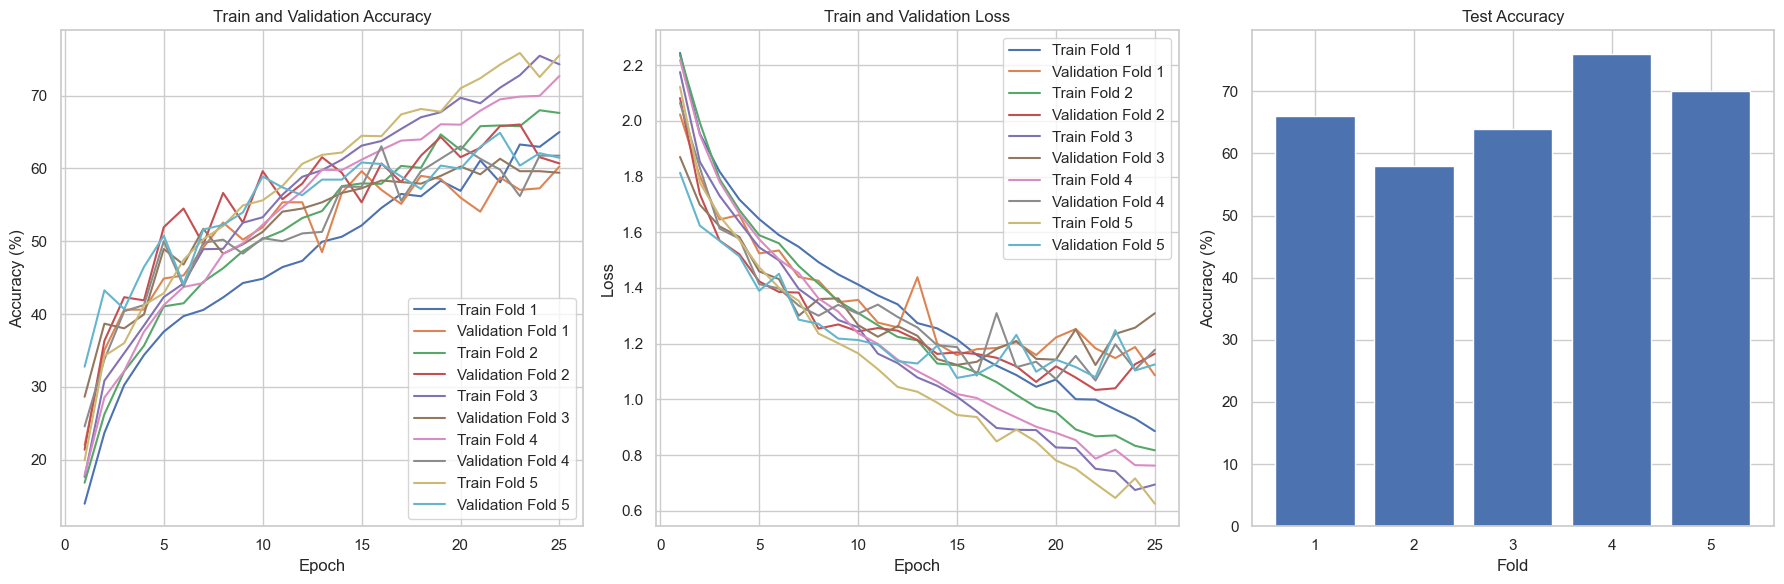

In [174]:
# Plot the results
sns.set(style="whitegrid")
epochs = range(1, EPOCHS + 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Train and validation accuracy plot
axes[0].set_title("Train and Validation Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy (%)")

for i in range(N_FOLDS):
    axes[0].plot(epochs, all_train_accuracies[i], label=f"Train Fold {i+1}")
    axes[0].plot(epochs, all_val_accuracies[i], label=f"Validation Fold {i+1}")

axes[0].legend()

# Train loss plot
axes[1].set_title("Train and Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

for i in range(N_FOLDS):
    axes[1].plot(epochs, all_train_losses[i], label=f"Train Fold {i+1}")
    axes[1].plot(epochs, all_val_losses[i], label=f"Validation Fold {i+1}")

axes[1].legend()

# Test accuracy
axes[2].set_title("Test Accuracy")
axes[2].set_xlabel("Fold")
axes[2].set_ylabel("Accuracy (%)")
axes[2].bar(range(1, N_FOLDS + 1), all_test_accuracies)

plt.tight_layout()
plt.show()

# ResNet-50 Implementation

## Imports

In [175]:
# Imports

import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## Hyperparameters

In [176]:
# Hyperparameters:
batch_size = 32
learning_rate = 0.00004
num_epochs = 12
k_folds = 3
num_classes = 10
dropout_rate = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weight_decay = 0.01

## Load pre-trained ResNet-50 model apply modifications

In [177]:
# Load pre-trained ResNet-50 model and modify the final layer with dropout
resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Modify the fully connected layer by adding Dropout
resnet.fc = torch.nn.Sequential(
    torch.nn.ReLU(),  # Activation function
    torch.nn.Dropout(p=dropout_rate),  # Dropout layer with the dropout rate hyperparameter
    torch.nn.Linear(resnet.fc.in_features, num_classes)  # Final fully connected layer with num_classes output
)

# Move the model to the device (GPU if available)
resnet = resnet.to(device)

## Apply Transforms + Load Datasets

In [178]:
# Load the CSV containing image paths
csv_path = './data/WILDCATS.CSV'
df = pd.read_csv(csv_path)

# define column names
df.columns = ['class id', 'filepaths', 'labels', 'data set', 'scientific name']

# split the data into training and testing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=70)

# A class responisble the image loading
class BigCatDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data.copy()  # Create a copy of the DataFrame to avoid modifying the original one
        self.transform = transform
        self.base_path = './data/'  # Base directory for images

        # Initialize the LabelEncoder and fit it to the class labels
        self.label_encoder = LabelEncoder()
        self.data.loc[:, 'encoded_labels'] = self.label_encoder.fit_transform(self.data.iloc[:, 2])

    def __len__(self):
        return len(self.data) # Return the length of the dataset

    def __getitem__(self, idx):
        # Error check
        if 'encoded_labels' not in self.data.columns:
            raise KeyError("The column 'encoded_labels' is missing in the DataFrame.")

        # Construct the full path to the image
        img_path = self.base_path + self.data.iloc[idx, 1]  # Adjust column index if needed

        # Use iloc instead of loc for integer-based indexing
        label = self.data.iloc[idx, self.data.columns.get_loc('encoded_labels')]  # Use the encoded label

        # Open and convert image to RGB format
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            raise
        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label, img_path

# Define transformations for images
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly resize and crop
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# Create dataset instances for training and testing
train_dataset = BigCatDataset(train_df, transform=transform)
test_dataset = BigCatDataset(test_df, transform=transform)

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Test loader does not shuffle

## Training the model using k-fold validation

In [179]:


# K-fold cross-validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_results = []

# Initialize lists to store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_model = None  # Track the best model
best_val_accuracy = 0.0  # Track the best validation accuracy

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):  # Note: train_dataset is used for the subset indices
    print(f"Training fold {fold + 1}/{k_folds}")

    # Create training and validation subsets from the train_dataset
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)  # Using train_dataset for validation dataset

    # Create DataLoader for training and validation subsets
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, drop_last=True)  # Drop last incomplete batch

    # Initialize model and move to device
    model = resnet.to(device)

    # Define the loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)

    # Tracking metrics for this fold
    fold_train_losses, fold_val_losses = [], []
    fold_train_accuracies, fold_val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        # Train the model
        for batch_idx, (images, labels, paths) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy for the epoch
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation loop
        model.eval()
        correct, total = 0, 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels, paths in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy for the epoch
        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total

        # Store per-epoch metrics
        fold_train_losses.append(train_loss)
        fold_train_accuracies.append(train_accuracy)
        fold_val_losses.append(val_loss)
        fold_val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Check if this fold's model is the best model so far
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model.state_dict()

    # Append fold results for later analysis
    train_losses.append(fold_train_losses)
    val_losses.append(fold_val_losses)
    train_accuracies.append(fold_train_accuracies)
    val_accuracies.append(fold_val_accuracies)

torch.save(best_model, 'best_model.pth')

Training fold 1/3
Epoch [1/12], Train Loss: 2.2542, Train Accuracy: 18.92%
Validation Loss: 2.1670, Validation Accuracy: 34.69%
Epoch [2/12], Train Loss: 2.0057, Train Accuracy: 50.46%
Validation Loss: 1.7291, Validation Accuracy: 60.94%
Epoch [3/12], Train Loss: 1.4777, Train Accuracy: 67.31%
Validation Loss: 1.0443, Validation Accuracy: 75.62%
Epoch [4/12], Train Loss: 0.9674, Train Accuracy: 74.46%
Validation Loss: 0.7102, Validation Accuracy: 81.56%
Epoch [5/12], Train Loss: 0.6611, Train Accuracy: 80.62%
Validation Loss: 0.5391, Validation Accuracy: 83.91%
Epoch [6/12], Train Loss: 0.5225, Train Accuracy: 84.92%
Validation Loss: 0.4939, Validation Accuracy: 86.56%
Epoch [7/12], Train Loss: 0.4422, Train Accuracy: 86.85%
Validation Loss: 0.3968, Validation Accuracy: 87.81%
Epoch [8/12], Train Loss: 0.3882, Train Accuracy: 89.38%
Validation Loss: 0.3949, Validation Accuracy: 88.59%
Epoch [9/12], Train Loss: 0.3233, Train Accuracy: 90.85%
Validation Loss: 0.3549, Validation Accuracy:

## Load the final best model and evaluate

In [180]:
# Load the final best model (resnet50 with custom fully connected layer)
final_model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Modify the fully connected layer to match the structure used during training
final_model.fc = torch.nn.Sequential(
    torch.nn.ReLU(),  # Activation function
    torch.nn.Dropout(p=dropout_rate),  # Dropout layer with the dropout rate hyperparameter
    torch.nn.Linear(final_model.fc.in_features, num_classes)  # Final fully connected layer with num_classes output
)


final_model.load_state_dict(torch.load('best_model.pth'))  # **Changed to 'best_model.pth'**

# Move the model to the device (GPU if available)
final_model = final_model.to(device)  # Move the model to the device AFTER loading the weights

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []
misclassified_images = []
misclassified_true_labels = []
misclassified_predicted_labels = []

# Set the model to evaluation mode (disable dropout, batch norm updates, etc.)
final_model.eval()

# Evaluation loop for the test set
with torch.no_grad():  # No need to compute gradients for evaluation
    for i, (images, labels, paths) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to device (GPU if available)

        # Get predictions from the model
        outputs = final_model(images)
        _, predicted = torch.max(outputs, 1)

        # Store true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

        # Save misclassified image paths and labels
        for j in range(images.size(0)):
            if predicted[j] != labels[j]:  # If prediction is wrong
                misclassified_images.append(paths[j])  # Save the path of misclassified image
                misclassified_true_labels.append(labels[j].cpu().item())  # True label
                misclassified_predicted_labels.append(predicted[j].cpu().item())  # Predicted label

# Print the total number of misclassified images
print(f"Total number of misclassified images: {len(misclassified_images)}")

# Calculate and print final test accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Final Test Accuracy: {accuracy * 100:.2f}%")

C:\Users\catha\AppData\Local\Temp\ipykernel_18308\4037696747.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('best_model.pth'))  

Total number of misclassified images: 27
Final Test Accuracy: 94.47%


## Plots and Graphs

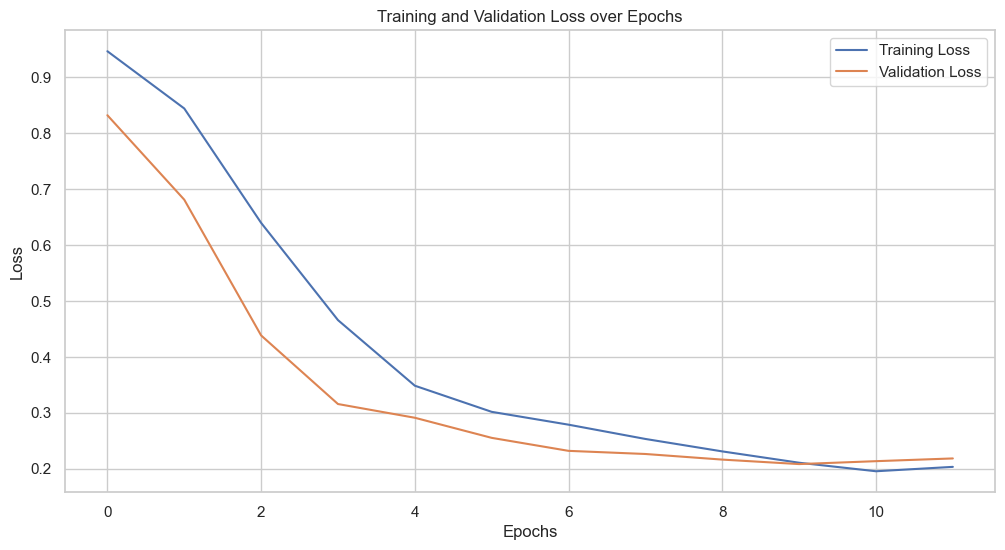

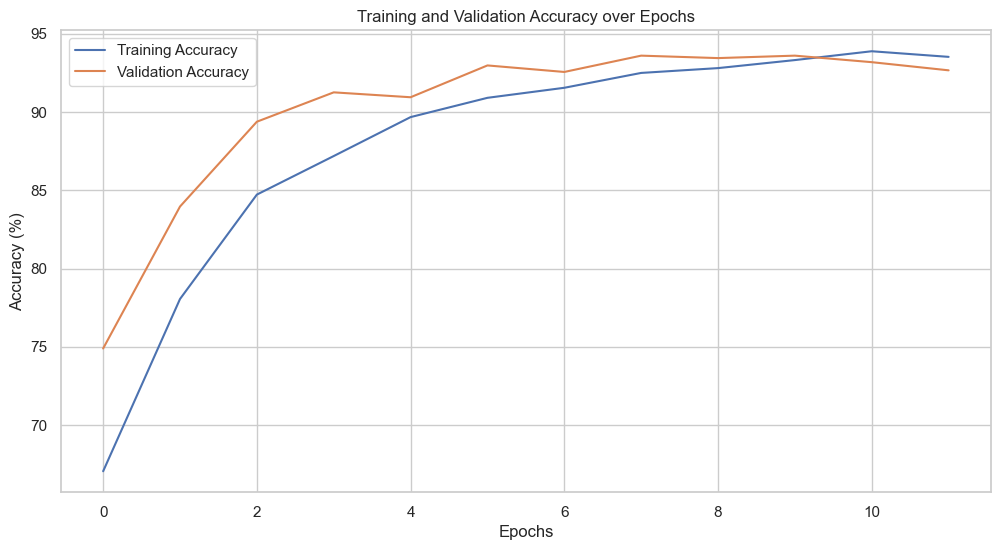

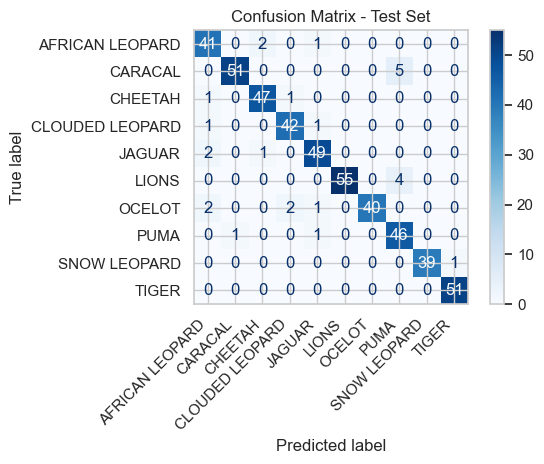

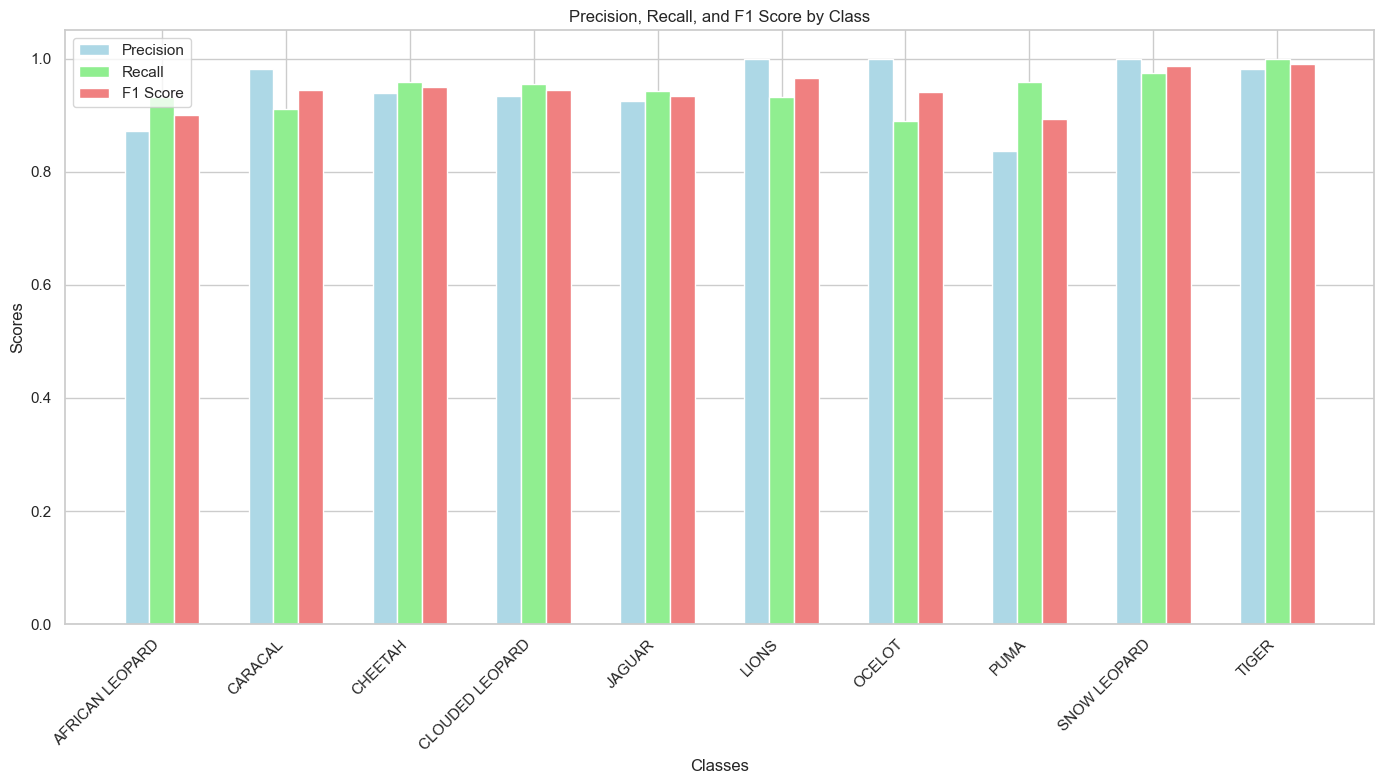

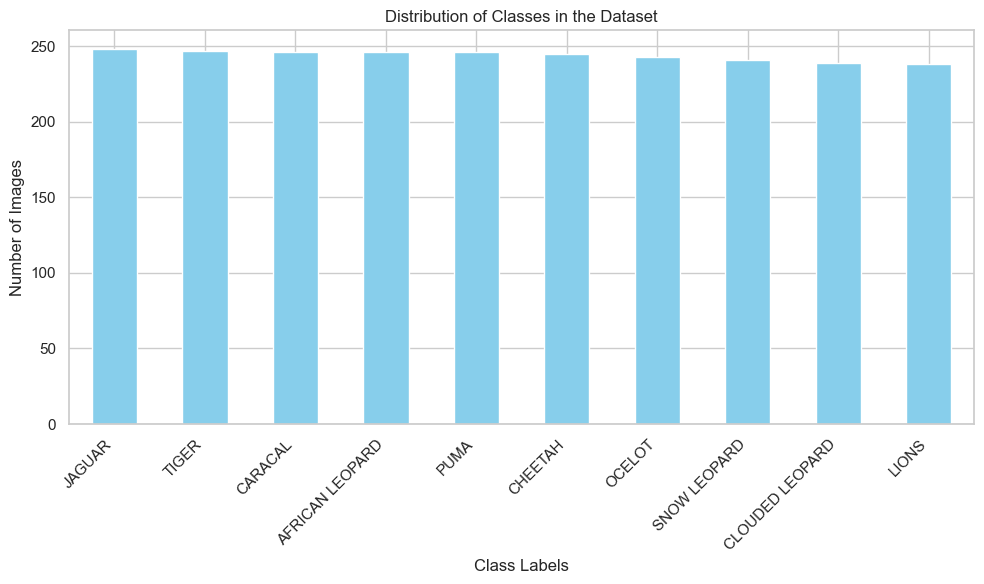

10 examples of misclassified images


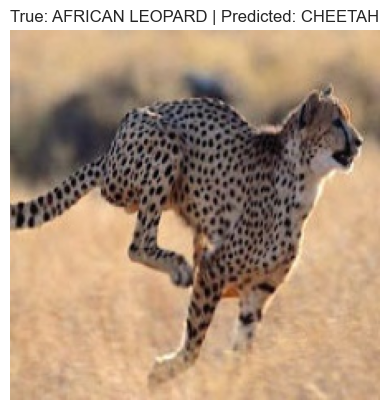

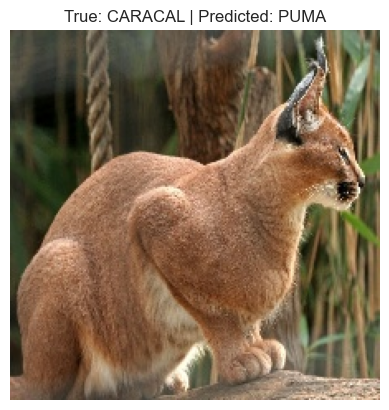

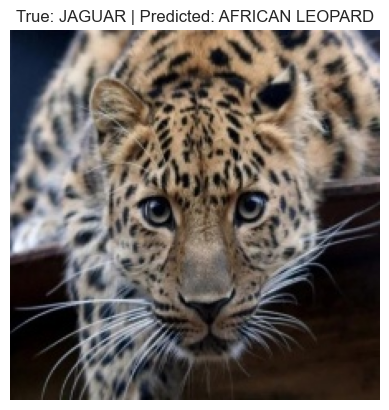

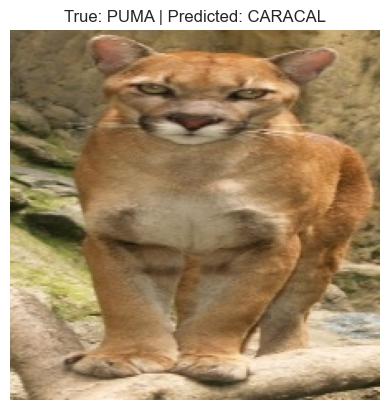

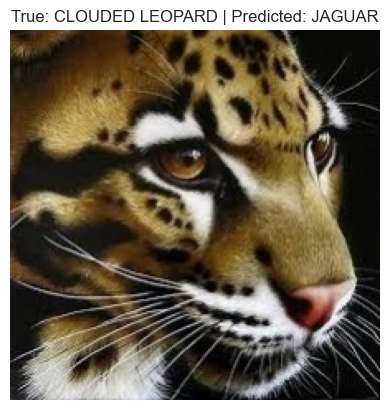

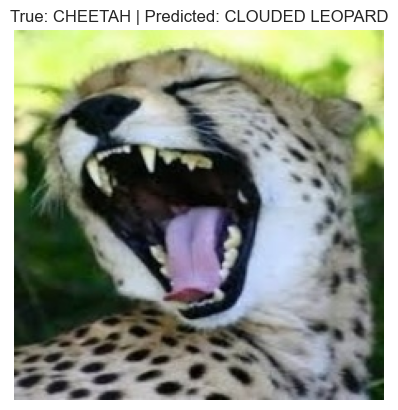

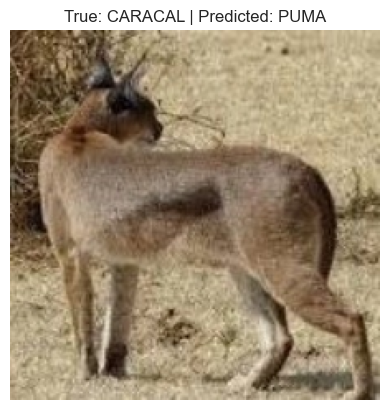

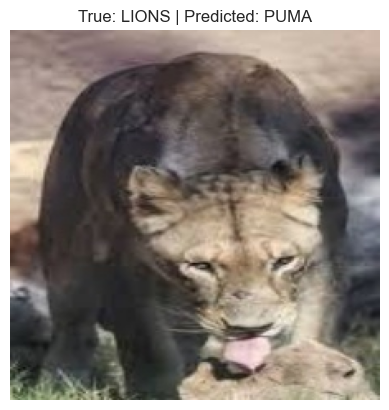

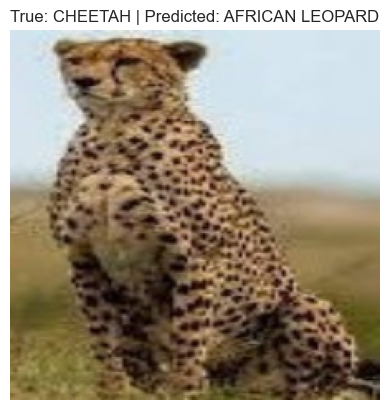

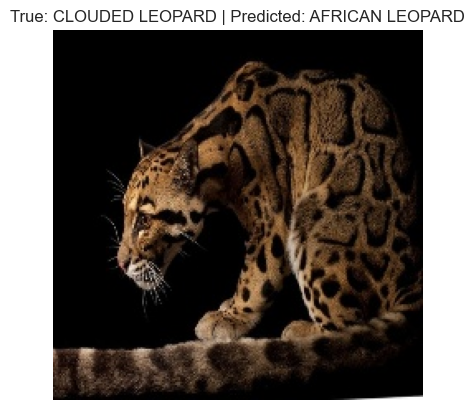

In [181]:


# Plotting Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(np.mean(train_losses, axis=0), label="Training Loss")
plt.plot(np.mean(val_losses, axis=0), label="Validation Loss")
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(np.mean(train_accuracies, axis=0), label="Training Accuracy")
plt.plot(np.mean(val_accuracies, axis=0), label="Validation Accuracy")
plt.title("Training and Validation Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

# Create and display the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=train_dataset.label_encoder.classes_)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)

# Rotate the x-axis labels for better spacing
plt.xticks(rotation=45, ha='right')

# Add title
plt.title('Confusion Matrix - Test Set')

# Show the plot
plt.tight_layout()
plt.show()

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=train_dataset.label_encoder.classes_, output_dict=True)

# Extract precision, recall, and F1-score for each class
precision = [report[label]['precision'] for label in train_dataset.label_encoder.classes_]
recall = [report[label]['recall'] for label in train_dataset.label_encoder.classes_]
f1_score = [report[label]['f1-score'] for label in train_dataset.label_encoder.classes_]

# Bar chart for precision, recall, and F1-score
x = np.arange(len(train_dataset.label_encoder.classes_))
width = 0.2  # Bar width

plt.figure(figsize=(14, 8))
plt.bar(x - width, precision, width, label='Precision', color='lightblue')
plt.bar(x, recall, width, label='Recall', color='lightgreen')
plt.bar(x + width, f1_score, width, label='F1 Score', color='lightcoral')

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1 Score by Class')
plt.xticks(x, train_dataset.label_encoder.classes_, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Visualization of key attributes (e.g., class distribution)
plt.figure(figsize=(10, 6))
df['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Classes in the Dataset')
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


print("10 examples of misclassified images")


# Display misclassified images
for i in range(min(10, len(misclassified_images))):
    img_path = misclassified_images[i]
    true_label = train_dataset.label_encoder.inverse_transform([misclassified_true_labels[i]])[0]
    predicted_label = train_dataset.label_encoder.inverse_transform([misclassified_predicted_labels[i]])[0]

    # Load the image for display
    img = Image.open(img_path).convert('RGB')


    # Plot the image with true and predicted labels
    plt.figure()
    plt.imshow(img)
    plt.title(f"True: {true_label} | Predicted: {predicted_label}" )
    plt.axis('off')
    plt.show()



# Overview

For this project, we chose to implement convulutional neural networks based on the LeNet-5 and Resnet architecture. Our CNNs are trained to identify the correct type of big cat from an image.

# The Data Set

The dataset we used for this assignment contains images of wildcats, which are classified into 10 categories. These being African leopard, caracal, cheetah, clouded leopard, jaguar, lions, ocelot, puma, snow leopard and tiger. The dataset consists of 2440 coloured 224x224px images with around 245 images per category. This means that the dataset is well balanced as we can see in the class distribution diagram below. Another important point of note for this data set is that it includes images that are blurry as well as photos taken of the cats in different states such as running, sleeping or facing in different directions. Lighting conditions vary significantly, and there is species-specific variation, such as difference in fur colour, patterns, etc. This allows the model to train to identify the cats well but also means that some of the images can be harder to identify later in the testing phase. The original dataset was split 96% training, 2% testing and 2% validation. This however only left 5 images for testing the model which we did not feel was good enough to get accurate results so we decided to instead use our own splits to divide the dataset.

For the LeNet model we applied K-fold validation when training the model, therefore fully utilizing the dataset. For testing the performance of the model after each fold, we tested on unseen test data from the test subfolder. We also applied various transformations such as flipping the image to make our model more suitable for unseen data.

For the ResNet model we split the data into 80% training and 20% testing. We also utilised techniques such as resizing, cropping, and normalizing, ensuring that all the inputs the model receives are consistent in size and range. We also utilised some augmentation techniques like random resizing and horizontal flipping that are applied to increase model abilty to handle the variability in image data and leads to better generalization.

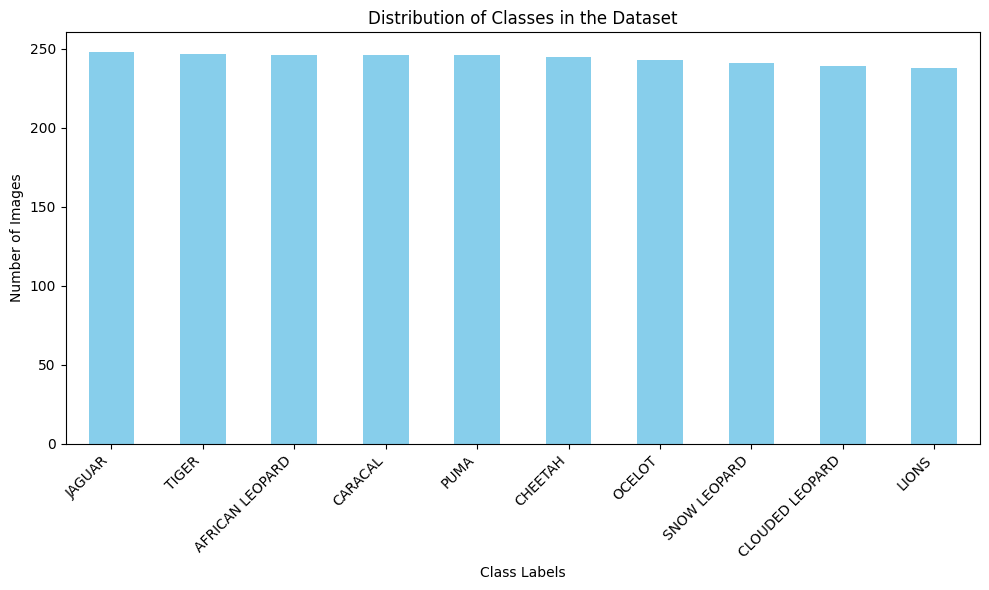





# The Network Structure

## ResNet
For our ResNet model we utilised transfer learning by implementing a modified ResNet-50 architecture with weights pre-trained on the ImageNet dataset allowing us to have a strong starting point
One of the core reasons we choose ResNet was due to its abilty to avoid the vansihing gradients problem by utilising residual learning and skip connections. Residual learning is the concept that instead of learning the desired mapping directly the network learns the residual of that mapping, which simplifies optimization. Skip connections work by adding the input of a layer directly to the output of a deeper layer which allows the network to learn identity mappings more easily. This is very useful in deep networks as it avoids the degradation of accuracy as depth which is a common issue in networks as the depth increases.

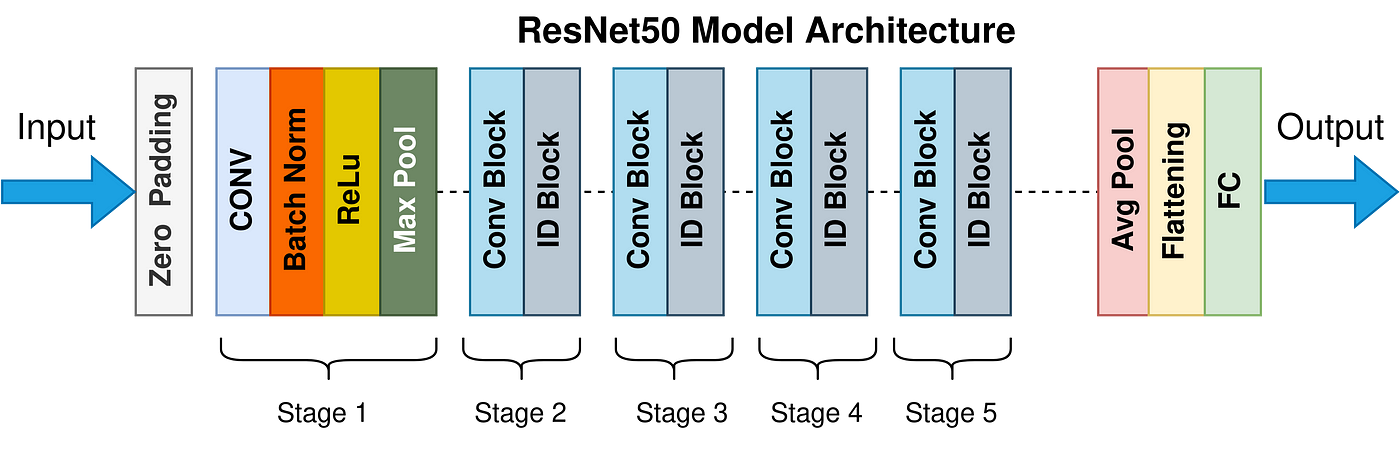 

We modified the final fully connected layer of ResNet to incorporate a ReLU activation function which introduces non-linearity and allows for more complex patterns to be learned. We elected to use the Adam optimiser and integrated data augmentation and normalization to enhance generalization

### Impact of varying Hyperparameters

**dropout:** set to 0.1 to prevent overfitting without damaging the accuracy too much.

**batch_size:** We settled on 32 but also tried batch sizes of 16 and 64 but these caused our accuracy results to be less stable

**num_epochs:** This models seems to converge at about 8 epochs but we setteled on 12 to have to best visualistion of the models performace while not causing the training time to get to high

**learning_rate** We started off with a value of 0.001 and the model seemed to converge very slowly. Initialy we theroised this was due to the learning rate being too low so we expiermented with a few values for higher learning rate that only worsned the problem. The results began to improve dramatically when we started trying lower learning rate numbers and we eventually settled on a quite smalle value of of 0.00004

**weight_decay:** We found that a value of 0.1 provided us the best results for this model

## LeNet-5

The original LeNet-5 model was desgined for 28x28px grayscale images, so it was necessary to adapt the model with minimal adjustments. The model has 3 convulutional layers. In the first layer we had to modify the single input channel (grayscale), to allow for a triple input channel (RGB). The first layer applies 6 filters of size 5x5. The second layer applies 16 filters of size 5x5. The third convolutional layer uses 120 filters of size 5x5. After each conv layer, we use an average pooling layer of size 2x2 and a stride of 2. The final output of the conv layers is then flattened to a vector of size 69,120. In relation to the fully connected layers, the first maps the flattened vector to 84 neurons, using ReLU for non-linearity. Dropout is then applied to reduce overfitting. The second fully connected layer then maps the 84-dimensional vector to 10 output neurons, we set this to 10 as that is the number of different outcomes(types of cat) in our dataset.

<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-18-12-47-59.png" width="600"/>

### Impact of varying Hyperparameters
#### Batch Size
The batch size of 16 gave us a good balance between computational cost and performance. Larger batch sizes provided similar results, but a batch size of 16 performed better than them.
#### Learning Rate
The learning rate was set to 0.0005 to allow the model to make small adjustments and refinements. This learning rate allowed convergence to occur at a good rate. Lower rates caused convergence to happen too slowly, while higher rates caused underfitting.
#### Epochs
We set the number of epochs for 25 to give enough learning that allowed convergence to take place, adding more epochs caused overfitting to occur. Less epochs reduced the performance of the model.
#### Dropout
We set the dropout rate to be 0.5 as it provided increased generalization. The model suffered from severe overfitting without dropout and mild overfitting with dropouts less than 0.5. The model suffered from underfitting with dropout rates higher than 0.5, and the model took longer to converge.
#### K-Folds
We found 5 k fold layers to be the optimal considering our dataset size. 5 folds provided us a nice balance between training and validation data, reducing overfitting and underfitting and also being a reasonable number computationally to run. Lower numbers of layers such as 3 would reduce our training set and affected our model to generalize negatively. A higher number of layers such as 8 would reduce our validation set and cause huge variance in performance across the layers making it difficult to evaluate the performance of the model.


# The Loss Function

For the loss function of both architectures we chose cross-entropy. Cross-entropy is a suitable loss function for our model as we are dealing with the classification of data, specifically images. Cross-entropy measures the distance between the predicted labels of the data and the actual labels. This function heavily penalizes outputs that assign low probabilities to true class and vice versa. This gives us a more accurate function for how well the model is performing and allows us to update our weights accordingly to improve the performance of the model.

# The Optimizer

For both models we chose the Adam optimiser. This optimiser efficiently handles noisy and sparse gradients, such as our one, this ensures stability in training when the gradient has large variance. Bias correction secures more reliable updates, especially at the early stages of training. The adam optimiser adapts the learning rate for each parameter throughout the training process, this reduces the burden for us in tuning the hyperparameters. The adam optimiser causes convergence to happen more rapidly, reducing the amount of epochs required for us to train the model, while maintaining a high level of model performance. This saves us a lot of time and computational power. Overall the adam optimiser is renowned for its smooth convergence and efficient optimisation of models of all sorts. For ResNet we also added a weight decay of 0.01 to aid regularization.

# Cross Fold Validation

To get a better understanding of how our model is performing across the dataset, we used K-Fold validation. Applying k-fold to our model allowed us to confirm that we were not overfitting our model as instead of one train-validation split, we used k. By using k-fold validation, we also ensure that every part of our dataset is used for both training and validation, maximizing our utilization of the data as no portion is left out. The metrics provided to us from k-fold validation are much more accurate in the sense that they give us a far greater outlook into the real-world performance of our model on unseen data as we have split our sets k times. In other words, we are able to have a more reliable opinion of how our model that will generalize better on new, unseen data. The cross validation helps to reduce bias in the model.

For LeNet we used 5-fold cross-validation, which was suitable for the more classic model.

For ResNet we used 3-fold cross-validation due to its longer training times and computational cost.

# Results


## ResNet

For ResNet we were getting very comparable validation and training accuracies in the cross validation that steadily increased until settling at around 95%. We then tested the model on completely unseen data which achieved an accuracy of 92%. We achieved stable validation on training losses and created graphs to analyze a few key performance metrics for each of the class such as a confusion matrix as well as a graph to visualize the recall precision and f-1 scores. The confusion matrix was chosen because is especially useful for investigating what classes are underperforming in predictions and what they are getting confused with which can give us ideas on what changes we would need to make to the model to correct the misclassifications. Similarly, the recall precision and f-1 score graph allows us to get a clear look at how each class is performing and whether the models' issues lie in false positives or false negatives. All these graphs can be seen below.

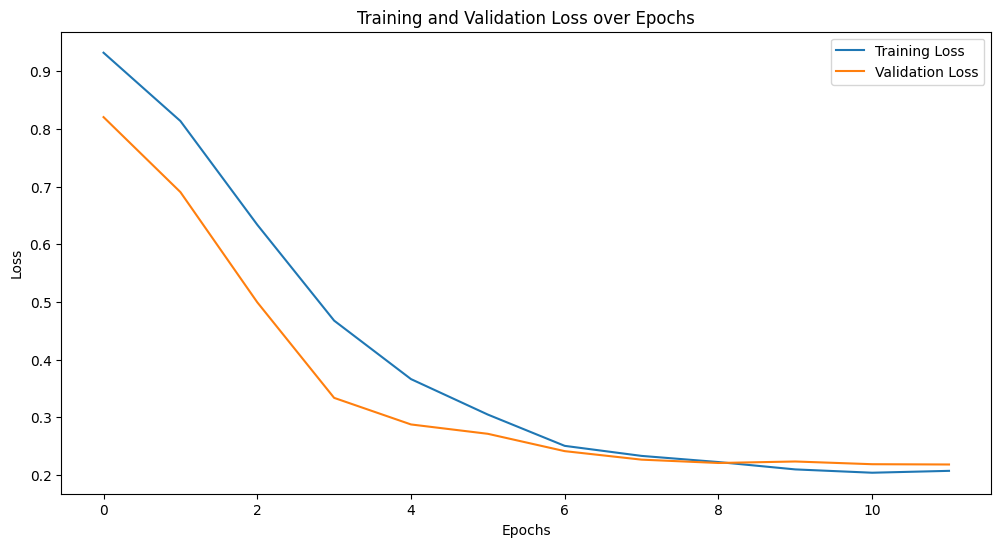
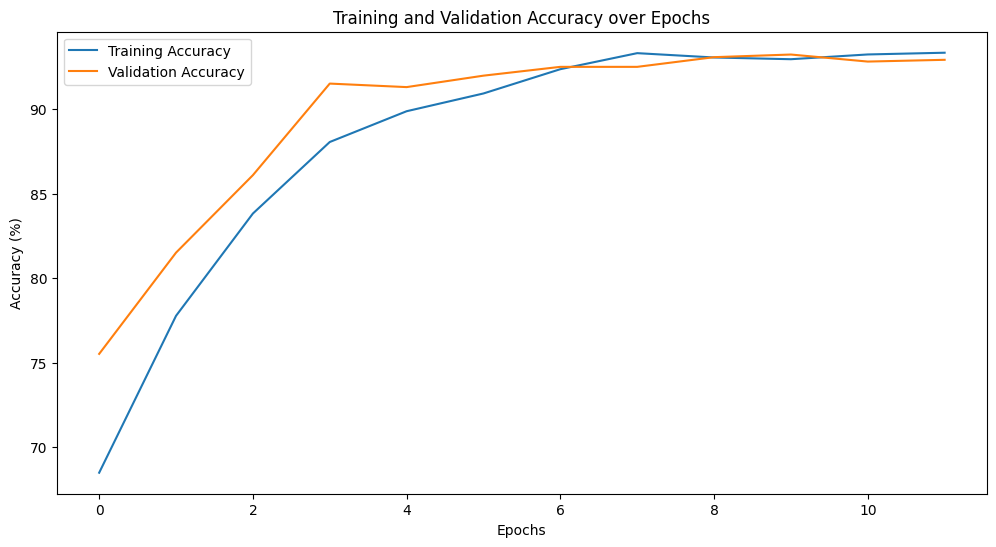 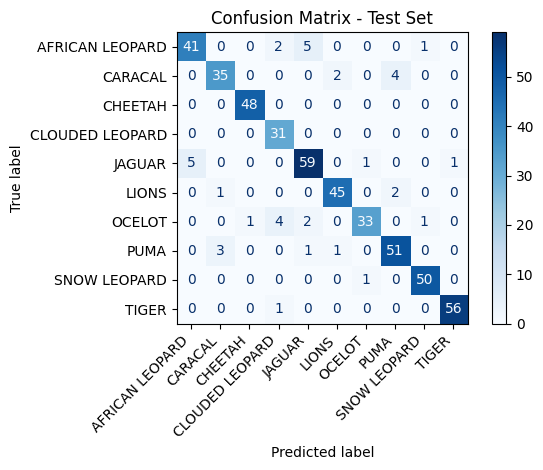 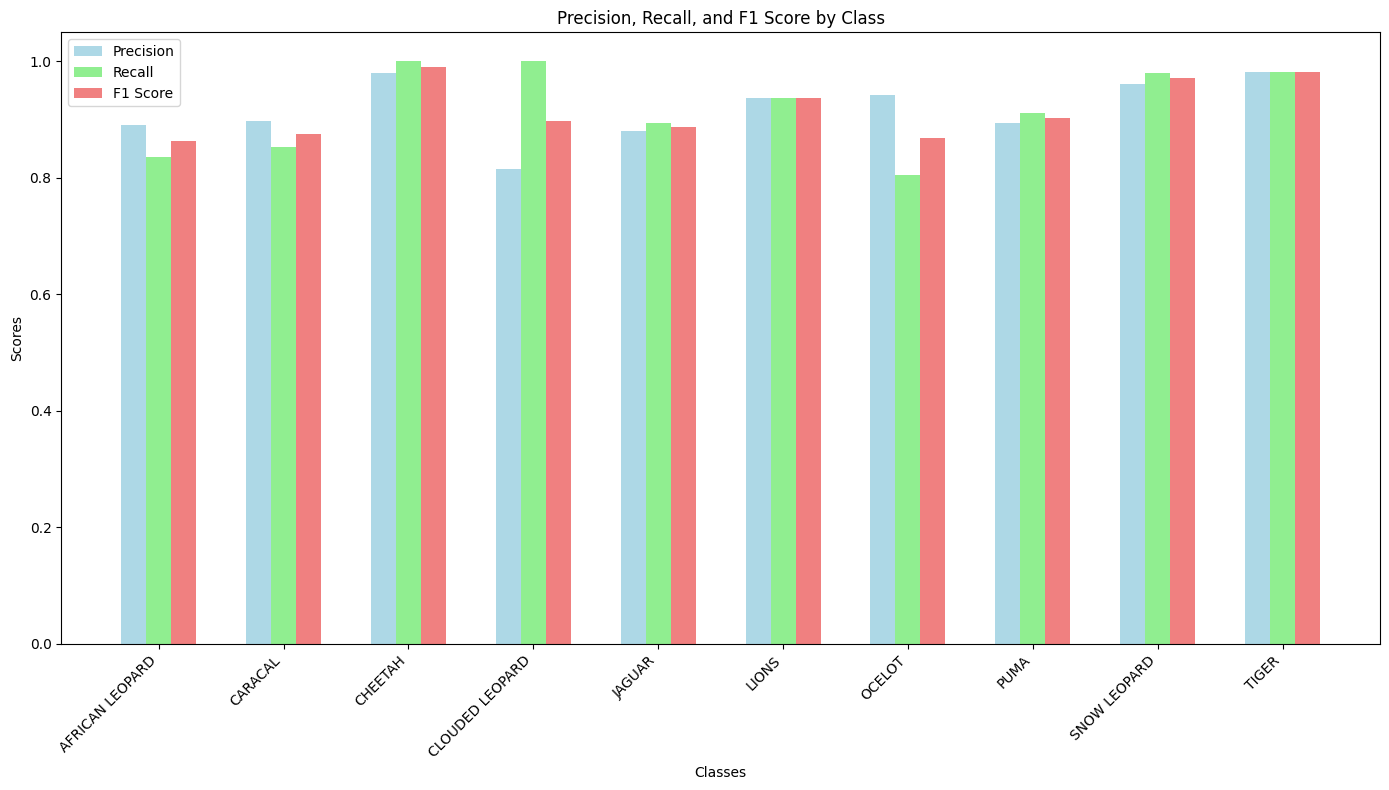

## LeNet

We started off on a relatively low train and validation accuracy of Our test accuracy varied across folds from ~ 60-80%. Our model leveled out at approximately 65% validation accurracy after about 25 epochs, further epochs caused overfitting. 

Epoch 5/25 Training: 100%|██████████| 117/117 [00:05<00:00, 21.27it/s, accuracy=37.6, loss=1.68]
Epoch 5/25, Train Loss: 1.6472, Train Accuracy: 37.57%
Epoch 5/25 Validation: 100%|██████████| 30/30 [00:00<00:00, 41.08it/s, accuracy=44.9]

For ResNet we were getting very comparable validation and training accuracies in the cross validation that steadily increased until settling at around 95%. We then tested the model on completely unseen data which achieved an accuracy of 92%. We achieved stable validation on training losses and created graphs to analyze a few key performance metrics for each of the class such as a confusion matrix as well as a graph to visualize the recall precision and f-1 scores. The confusion matrix was chosen because is especially useful for investigating what classes are underperforming in predictions and what they are getting confused with which can give us ideas on what changes we would need to make to the model to correct the misclassifications. Similarly, the recall precision and f-1 score graph allows us to get a clear look at how each class is performing and whether the models' issues lie in false positives or false negatives. All these graphs can be seen below

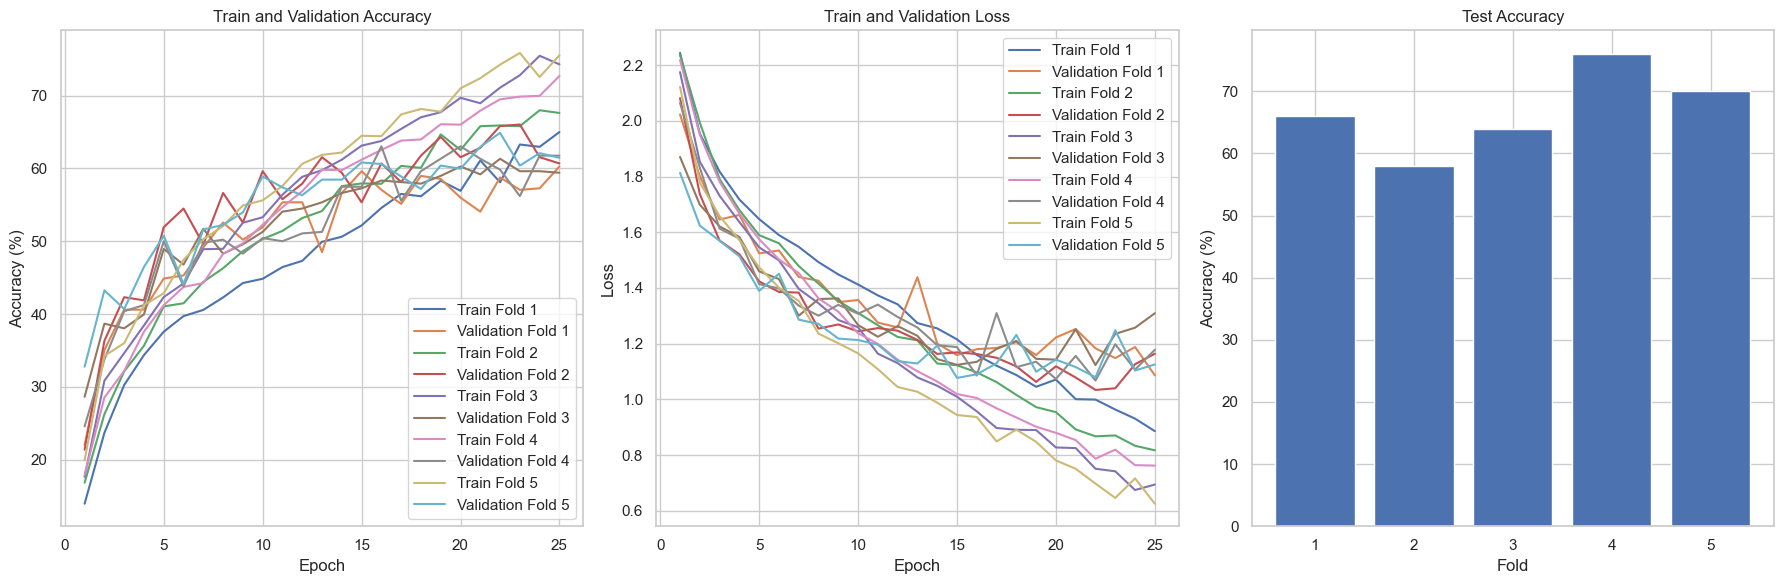

# Evalution of Results

## ResNet
The results of our ResNet model shows good performance overall with high accuracy across mosof the cat classes, but from analysing the graphs above we can draw a few conclusions on what deatils affected our results most. For instance, classes like Cheetah, Snow Leopard, and Tiger achieve near-perfect precision and recall due to their more distinct physical features such as heir unique coat patterns, distinctive body shapes and facial structures. On the other hand, the clouded leopard has high recall but lower precision which might indicate that the model is over attributing certain features to it than from other similar-looking cats. We can also see below how many of the misclassified images are close-ups where the model is unable to see more of the cats distinctive characteristics which makes accurate classification challenging.

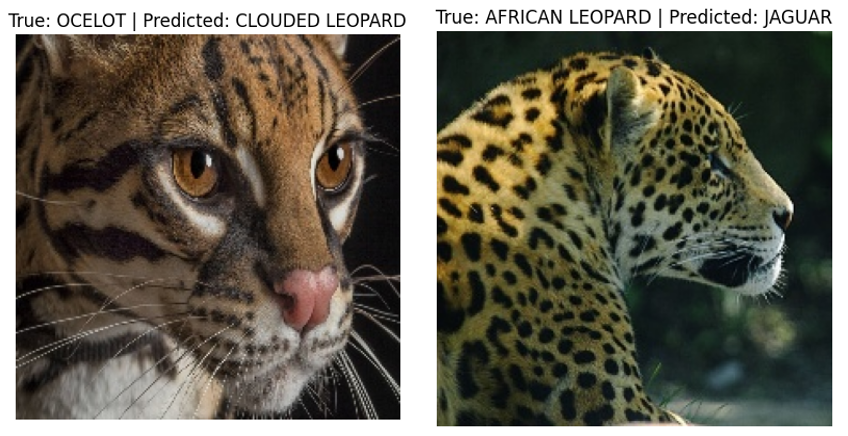

From our learning and validation loss graphs we can see that our model is able to avoid overfitting this is thanks to techniques such as dropout and L1 regularization. In the confusion matrix we can see that Jaguars and African Leopards are often confused which makes sense as these animals have similar size and shapes aswell as coat patterns and colours. The results of this model could be improved by adding more images to cover more of the tricky angles allowing the model to function better on the more difficult data.

## LeNet
While our results are reasonable given how dated this architecture is, the results are not acceptable to be used in a real world application. The age of the LeNet-5 architecture is evident, it was built for much smaller (28px) images of 1 color channel. It is incapable of handling the complexity of the dataset to a more acceptable degree of 90%+. While, test accuracy averages >70% across the 5 folds, we would realistically require something in range of 90%+ for the model to be of good use. The model is incapable of performing past the 80% range even after rigorous changing and tuning of hyperparameters. The model however, does not suffer from overfitting.

## Conclusion
In conclusion, it is evident that there have been great advancements in developments of convolutional neural networks since the 1998 implementation of the LeNet-5 architecture. Enhancements such as techniques like residual learning allow us to avoid common issues in networks such as the vanishing gradients problem. This massively boost the performance of these modern models. Models such as ResNet are much more suitable for more complex datasets with higher-resolution images with colouring, where LeNet had to be slightly  modified for compatibility (RGB) and still the performance is underwhelming. 

